In [292]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import DataSplitter

# Seasonality

In [293]:
def fourierTransform(seq):
    dft_seq = np.fft.fft(seq)
    return pd.Series(dft_seq)

def inverseFourierTransform(seq):
    idft_seq = np.fft.ifft(seq)
    return pd.Series(idft_seq)

In [310]:
np.set_printoptions(precision=2, suppress=True)
df = DataSplitter.getTrainData(60)

# not differenced
passengers = [df[(df["line"] == f"{i+1}A")]["passengersBoarding"].tolist() for i in range(6)]
# differenced
#passengers = [df[(df["line"] == f"{i+1}A")]["passengersBoarding"].diff(periods=1).fillna(0).tolist() for i in range(6)]

passengers_ft = [fourierTransform(passenger_line) for passenger_line in passengers]
nsamples = len(passengers[0])
print('samples', nsamples)

max_magnitude_of_passengers = []
for passenger_line in passengers_ft:
    max_magnitude_of_line = []
    norms = np.abs(passenger_line[:nsamples//2][1:])

    # pick the n largest but not DC
    amount_of_tops = 5
    max_index = np.argsort(norms)[-amount_of_tops::][::-1] + 1
    print(norms[max_index])
    # find the period
    print('periods in hours', 2*np.pi / (np.pi * max_index.values/(nsamples/2)))

    # 0-array except for largest magnitudes
    max_magnitude_of_line = np.zeros(nsamples)
    max_magnitude_of_line[max_index] = norms[max_index]

    # magnitude but where tops are set to 0
    #norms[max_index] = 0
    #max_magnitude_of_line = norms

    max_magnitude_of_passengers.append(max_magnitude_of_line + max_magnitude_of_line[::-1])


samples 16896
704     2.873052e+06
2112    7.920580e+05
603     4.723707e+05
1       4.542849e+05
101     4.353370e+05
dtype: float64
periods in hours [   24.       8.      28.02 16896.     167.29]
704     2.823436e+06
2112    6.706268e+05
101     4.589710e+05
603     4.296320e+05
503     3.864583e+05
dtype: float64
periods in hours [ 24.     8.   167.29  28.02  33.59]
704     1.998845e+06
2112    5.072788e+05
101     3.214135e+05
603     2.986858e+05
503     2.690556e+05
dtype: float64
periods in hours [ 24.     8.   167.29  28.02  33.59]
704     3.324890e+06
2112    1.060658e+06
101     6.263748e+05
603     5.747988e+05
4224    5.249077e+05
dtype: float64
periods in hours [ 24.     8.   167.29  28.02   4.  ]
704     1.514199e+06
2112    5.754787e+05
101     3.484586e+05
201     3.145255e+05
4       2.971383e+05
dtype: float64
periods in hours [  24.      8.    167.29   84.06 4224.  ]
704     2.420263e+06
2112    1.291176e+06
2816    7.897743e+05
101     7.083569e+05
4224    5.939121e

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


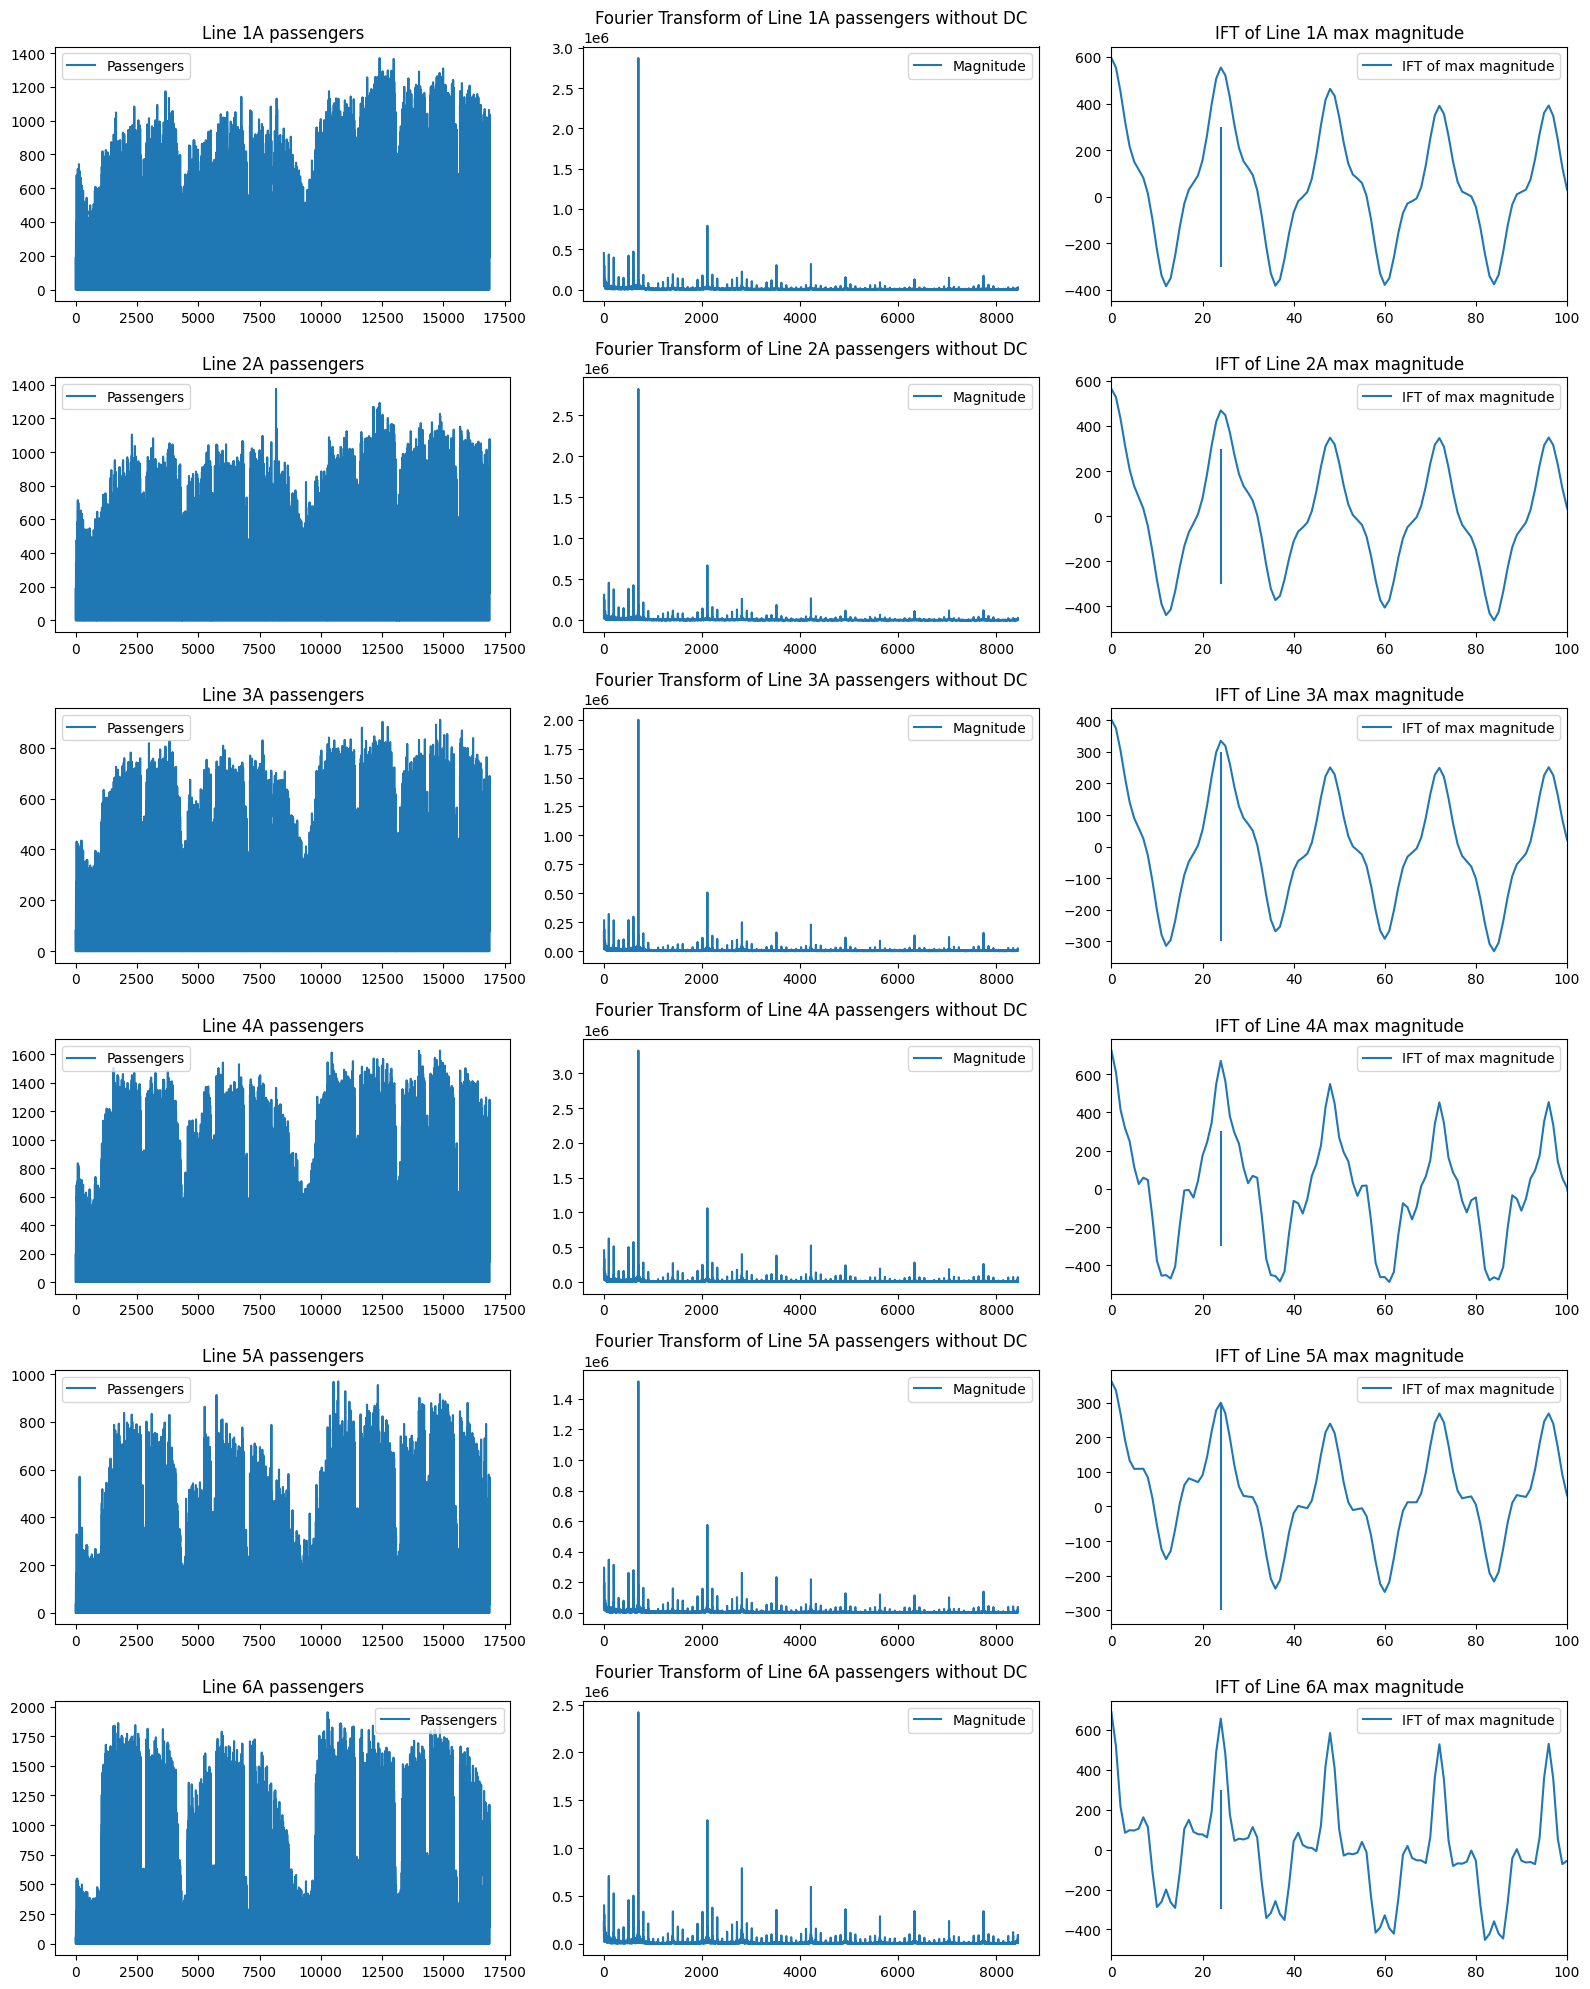

In [311]:
# Create a 3x4 grid of subplots
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(16, 20))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()

# Plot on each subplot
for i in range(0, 6):
    # plot passenger
    axes[i*3].plot(passengers[i], label=f"Passengers")
    axes[i*3].set_title(f"Line {i+1}A passengers")
    axes[i*3].legend()

    # plot frequency spectrum without DC
    mag = np.abs(passengers_ft[i][1:nsamples//2])
    axes[(i*3)+1].plot(mag, label=f"Magnitude")
    axes[(i*3)+1].set_title(f"Fourier Transform of Line {i+1}A passengers without DC")
    axes[(i*3)+1].legend()

    # plot inverse transform
    #axes[(i*3)+2].plot(inverseFourierTransform(max_magnitude_of_passengers[i][len(max_magnitude_of_passengers)//2:]), label=f"IFT of max magnitude")
    axes[(i*3)+2].plot(inverseFourierTransform(max_magnitude_of_passengers[i]), label=f"IFT of max magnitude")
    axes[(i*3)+2].set_title(f"IFT of Line {i+1}A max magnitude")
    axes[(i*3)+2].legend()
    axes[(i*3)+2].set_xlim([0, 100])
    axes[(i*3)+2].vlines(x=24, ymin=-300, ymax=300)

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

# Trend

In [183]:
df = DataSplitter.getTrainData(60)

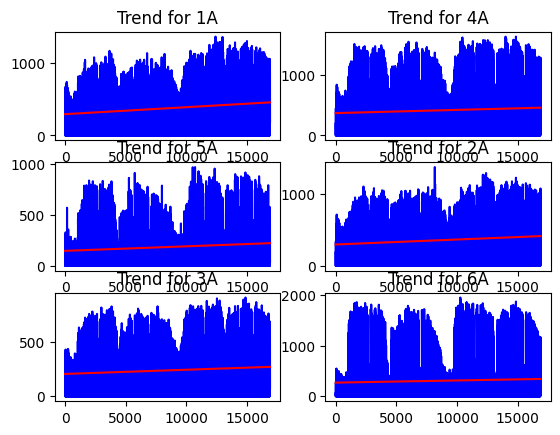

In [289]:
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

fig, ax = plt.subplots(3, 2)

for i, line in enumerate(['1A', '2A', '3A', '4A', '5A', '6A']):
    df_subset = df[df['line'] == line]
    df_subset = df_subset.reset_index(drop=True)

    # linear trend
    transformer = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
    y_detrend = transformer.fit_transform(df_subset['passengersBoarding'])

    ax[i % 3, i % 2].plot(y_detrend.index, df_subset['passengersBoarding'], color='blue')
    ax[i % 3, i % 2].plot(y_detrend.index, df_subset['passengersBoarding'] - y_detrend, color='red')
    ax[i % 3, i % 2].set_title(f'Trend for {line}')
plt.show()

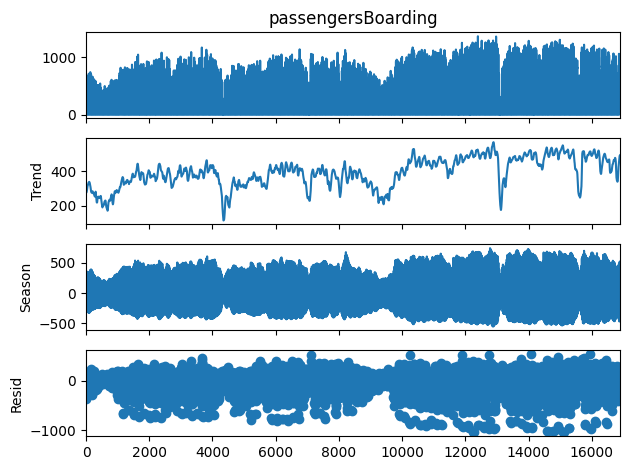

In [290]:
from statsmodels.tsa.seasonal import STL

df_subset = df[df['line'] == '1A']
df_subset = df_subset.reset_index(drop=True)
# STL decomposition
res = STL(df_subset['passengersBoarding'], period=24, seasonal=7, robust=True).fit()
plot = res.plot()
plt.show()

# Stationarity

In [186]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

df15 = DataSplitter.getTrainData(15)
df30 = DataSplitter.getTrainData(30)
df60 = DataSplitter.getTrainData(60)

In [187]:
def adf_test(series, alpha=0.05, hypothesis=False):
    # Extract test statistic and p-value
    test_statistic, p_value, _, _, _, _ = adfuller(series)
    if hypothesis:
        print("H_0: Time Series is not stationary")
        print("H_A: Time Series is stationary")
    if p_value < alpha:
        print(f"p-value: {p_value} < {alpha} (Stationary)")
    if p_value > alpha:
        print(f"p-value: {p_value} > {alpha} (Not Stationary)")
    if p_value == alpha:
        print(f"p-value: {p_value} = {alpha}")
    return test_statistic, p_value

def kpss_test(series, alpha=0.05, hypothesis=False):
    # Extract test statistic and p-value
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=InterpolationWarning)
        test_statistic, p_value, lags, _ = kpss(series)
    if hypothesis:
        print("H_0: Time Series is stationary")
        print("H_A: Time Series is not stationary")
    if p_value < alpha:
        print(f"p-value: {p_value} < {alpha} (Not Stationary)")
    if p_value > alpha:
        print(f"p-value: {p_value} > {alpha} (Stationary)")
    if p_value == alpha:
        print(f"p-value: {p_value} = {alpha}")
    print(f"lags: {lags}")
    return test_statistic, p_value, lags

### ADF tests

In [287]:
adf_results15 = []
adf_results30 = []
adf_results60 = []
for agg_level in [(15, df15, adf_results15), (30, df30, adf_results30), (60, df60, adf_results60)]:
    print(f"{agg_level[0]} min")
    adf_results_temp = []
    for line in ["1A", "2A", "3A", "4A", "5A", "6A"]:
        print(line)
        df_temp = agg_level[1][agg_level[1]['line'] == line].reset_index(drop=True)
        test_statistic, p_value = adf_test(df_temp['passengersBoarding'])
        adf_results_temp.append((line, test_statistic, p_value))
    agg_level[2].append(adf_results_temp)

15 min
1A
p-value: 0.0 < 0.05 (Stationary)
2A
p-value: 0.0 < 0.05 (Stationary)
3A
p-value: 0.0 < 0.05 (Stationary)
4A
p-value: 0.0 < 0.05 (Stationary)
5A
p-value: 0.0 < 0.05 (Stationary)
6A
p-value: 0.0 < 0.05 (Stationary)
30 min
1A
p-value: 2.2715808933596163e-24 < 0.05 (Stationary)
2A
p-value: 5.282451546920093e-27 < 0.05 (Stationary)
3A
p-value: 7.366779673472217e-27 < 0.05 (Stationary)
4A
p-value: 1.0805394570063971e-26 < 0.05 (Stationary)
5A
p-value: 1.629349741349328e-24 < 0.05 (Stationary)
6A
p-value: 1.2070717942044521e-23 < 0.05 (Stationary)
60 min
1A
p-value: 2.3859010064637647e-21 < 0.05 (Stationary)
2A
p-value: 1.0037041167020161e-25 < 0.05 (Stationary)
3A
p-value: 1.3040981442842073e-25 < 0.05 (Stationary)
4A
p-value: 1.4834345415749088e-27 < 0.05 (Stationary)
5A
p-value: 9.223451656240212e-27 < 0.05 (Stationary)
6A
p-value: 2.699590160472132e-29 < 0.05 (Stationary)


### KPSS tests

In [286]:
kpss_results15 = []
kpss_results30 = []
kpss_results60 = []
for agg_level in [(15, df15, kpss_results15), (30, df30, kpss_results30), (60, df60, kpss_results60)]:
    print(f"{agg_level[0]} min")
    kpss_results_temp = []
    for line in ["1A", "2A", "3A", "4A", "5A", "6A"]:
        print(line)
        df_temp = agg_level[1][agg_level[1]['line'] == line].reset_index(drop=True)
        test_statistic, p_value, n_lags = kpss_test(df_temp['passengersBoarding'])
        kpss_results_temp.append((line, test_statistic, p_value, n_lags))
    agg_level[2].append(kpss_results_temp)

15 min
1A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 139
2A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 141
3A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 139
4A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 137
5A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 136
6A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 128
30 min
1A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 94
2A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 95
3A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 94
4A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 93
5A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 92
6A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 84
60 min
1A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 44
2A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 43
3A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 43
4A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 44
5A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 50
6A
p-value: 0.01 < 0.05 (Not Stationary)
lags: 53


### ADF test - Differenced

In [281]:
adf_results15 = []
adf_results30 = []
adf_results60 = []
for agg_level in [(15, df15, adf_results15), (30, df30, adf_results30), (60, df60, adf_results60)]:
    print(f"{agg_level[0]} min")
    adf_results_temp = []
    for line in ["1A", "2A", "3A", "4A", "5A", "6A"]:
        print(line)
        df_temp = agg_level[1][agg_level[1]['line'] == line].reset_index(drop=True)
        test_statistic, p_value = adf_test(df_temp['passengersBoarding'].diff(periods=1).fillna(0))
        adf_results_temp.append((line, test_statistic, p_value))
    agg_level[2].append(adf_results_temp)

15 min
1A
p-value: 0.0 < 0.05 (Stationary)
2A
p-value: 0.0 < 0.05 (Stationary)
3A
p-value: 0.0 < 0.05 (Stationary)
4A
p-value: 0.0 < 0.05 (Stationary)
5A
p-value: 0.0 < 0.05 (Stationary)
6A
p-value: 0.0 < 0.05 (Stationary)
30 min
1A
p-value: 0.0 < 0.05 (Stationary)
2A
p-value: 0.0 < 0.05 (Stationary)
3A
p-value: 0.0 < 0.05 (Stationary)
4A
p-value: 0.0 < 0.05 (Stationary)
5A
p-value: 0.0 < 0.05 (Stationary)
6A
p-value: 0.0 < 0.05 (Stationary)
60 min
1A
p-value: 0.0 < 0.05 (Stationary)
2A
p-value: 0.0 < 0.05 (Stationary)
3A
p-value: 0.0 < 0.05 (Stationary)
4A
p-value: 0.0 < 0.05 (Stationary)
5A
p-value: 0.0 < 0.05 (Stationary)
6A
p-value: 0.0 < 0.05 (Stationary)


### KPSS test - Differenced

In [285]:
kpss_results15 = []
kpss_results30 = []
kpss_results60 = []
for agg_level in [(15, df15, kpss_results15), (30, df30, kpss_results30), (60, df60, kpss_results60)]:
    print(f"{agg_level[0]} min")
    kpss_results_temp = []
    for line in ["1A", "2A", "3A", "4A", "5A", "6A"]:
        print(line)
        df_temp = agg_level[1][agg_level[1]['line'] == line].reset_index(drop=True)
        test_statistic, p_value, n_lags = kpss_test(df_temp['passengersBoarding'].diff(periods=1).fillna(0))
        kpss_results_temp.append((line, test_statistic, p_value, n_lags))
    agg_level[2].append(kpss_results_temp)

15 min
1A
p-value: 0.1 > 0.05 (Stationary)
lags: 49
2A
p-value: 0.1 > 0.05 (Stationary)
lags: 12
3A
p-value: 0.1 > 0.05 (Stationary)
lags: 30
4A
p-value: 0.1 > 0.05 (Stationary)
lags: 132
5A
p-value: 0.1 > 0.05 (Stationary)
lags: 183
6A
p-value: 0.1 > 0.05 (Stationary)
lags: 249
30 min
1A
p-value: 0.1 > 0.05 (Stationary)
lags: 12
2A
p-value: 0.1 > 0.05 (Stationary)
lags: 39
3A
p-value: 0.1 > 0.05 (Stationary)
lags: 6
4A
p-value: 0.1 > 0.05 (Stationary)
lags: 51
5A
p-value: 0.1 > 0.05 (Stationary)
lags: 237
6A
p-value: 0.1 > 0.05 (Stationary)
lags: 1152
60 min
1A
p-value: 0.1 > 0.05 (Stationary)
lags: 26
2A
p-value: 0.1 > 0.05 (Stationary)
lags: 35
3A
p-value: 0.1 > 0.05 (Stationary)
lags: 40
4A
p-value: 0.1 > 0.05 (Stationary)
lags: 46
5A
p-value: 0.1 > 0.05 (Stationary)
lags: 38
6A
p-value: 0.1 > 0.05 (Stationary)
lags: 67


### ACF and PACF plots

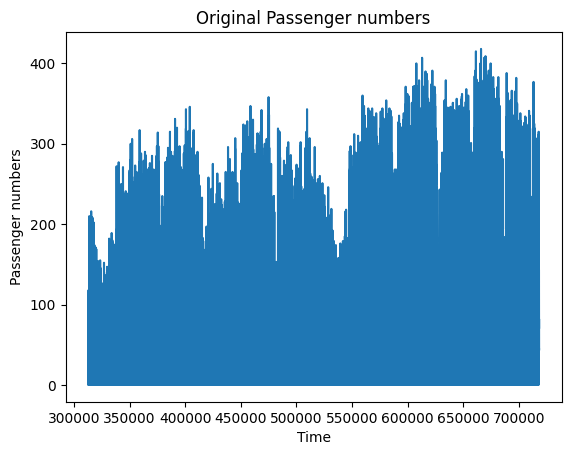

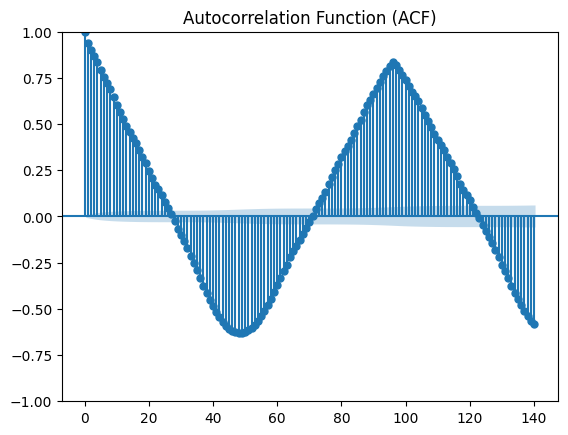

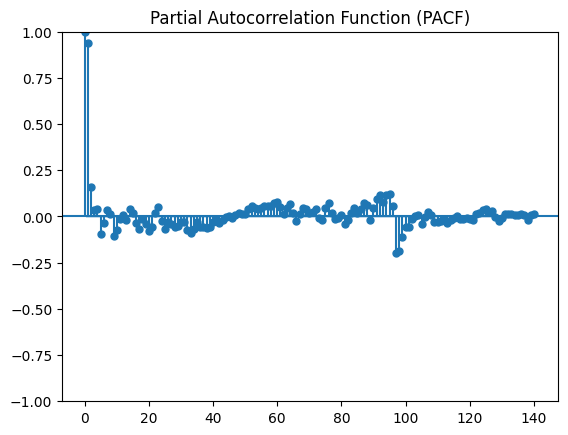

In [194]:
line = "1A"

# Plotting the original time series
plt.plot(df15[(df15["line"] == line)]["passengersBoarding"])
plt.title("Original Passenger numbers")
plt.xlabel("Time")
plt.ylabel("Passenger numbers")

# Plotting ACF (Autocorrelation Function)
plot_acf(df15[(df15["line"] == line)]["passengersBoarding"], lags=140, alpha=0.05)
plt.title("Autocorrelation Function (ACF)")

# Plotting PACF (Partial Autocorrelation Function)
plot_pacf(df15[(df15["line"] == line)]["passengersBoarding"], lags=140, alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()

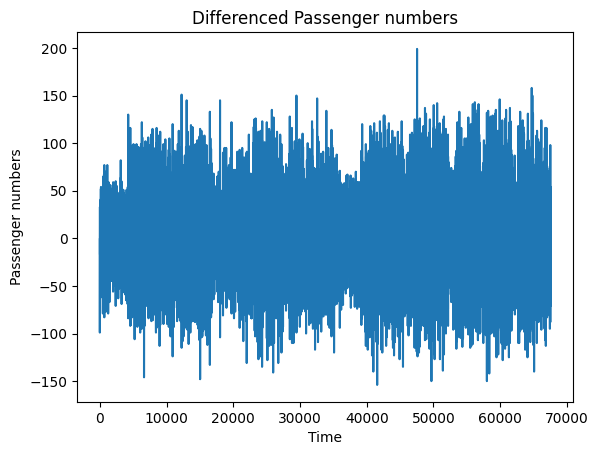

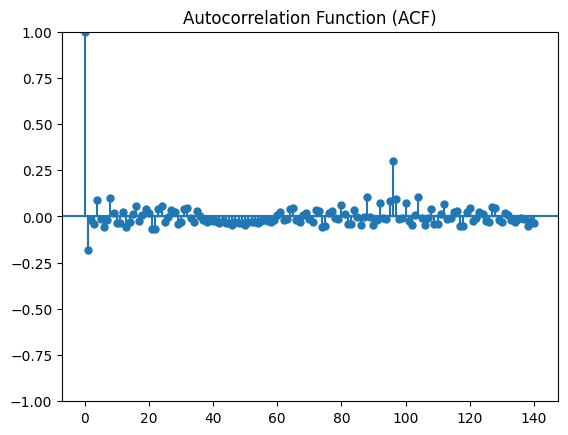

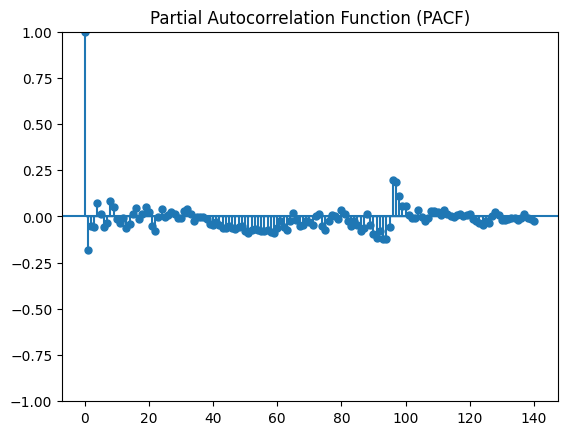

In [195]:
# Plotting the differenced time series
plt.plot(np.diff(df15[(df15["line"] == line)]["passengersBoarding"]))
plt.title("Differenced Passenger numbers")
plt.xlabel("Time")
plt.ylabel("Passenger numbers")

# Plotting ACF (Autocorrelation Function)
plot_acf(np.diff(df15[(df15["line"] == line)]["passengersBoarding"]), lags=140, alpha=0.05)
plt.title("Autocorrelation Function (ACF)")

# Plotting PACF (Partial Autocorrelation Function)
plot_pacf(np.diff(df15[(df15["line"] == line)]["passengersBoarding"]), lags=140, alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()

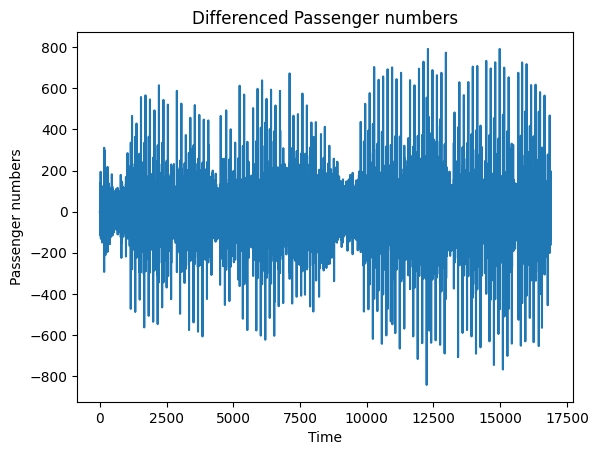

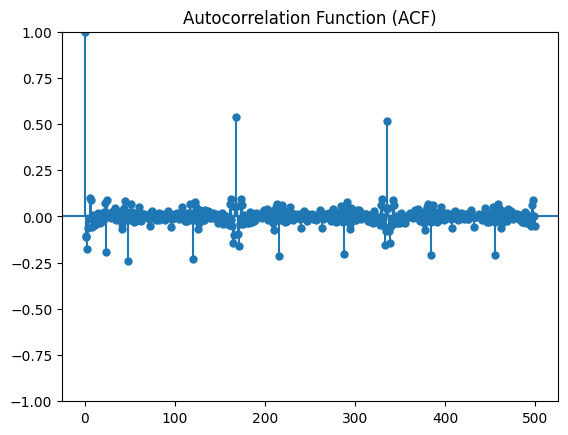

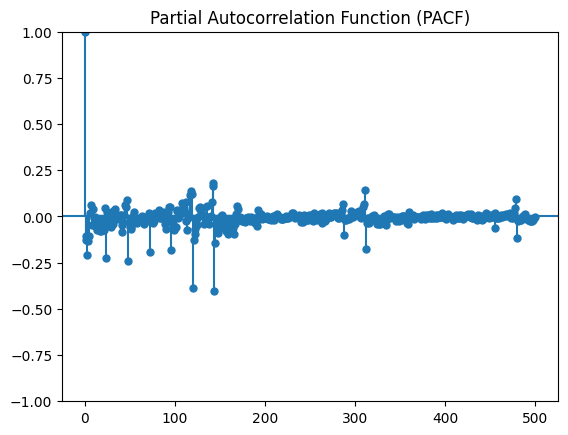

In [312]:
df_subset = df60[df60['line'] == '1A']
df_subset = df_subset.reset_index(drop=True)
# 1-difference
df_subset['diff1'] = df_subset['passengersBoarding'].diff(periods=1).fillna(0)
# seasonal difference
df_subset['diff24'] = df_subset['diff1'].diff(periods=24).fillna(0)

# Plotting the differenced time series
plt.plot(df_subset.index, df_subset['diff24'])
plt.title("Differenced Passenger numbers")
plt.xlabel("Time")
plt.ylabel("Passenger numbers")

# Plotting ACF (Autocorrelation Function)
plot_acf(df_subset['diff24'], lags=500, alpha=0.05)
plt.title("Autocorrelation Function (ACF)")

# Plotting PACF (Partial Autocorrelation Function)
plot_pacf(df_subset['diff24'], lags=500, alpha=0.05)
plt.title("Partial Autocorrelation Function (PACF)")

plt.show()

Tjek seasonal differencing eller prøv at subsette på f.eks. timebasis